## Импортируем необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

## Подготавливаем данные для обработки

In [3]:
df = pd.read_csv('features.csv', index_col='match_id')
df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [4]:
df_test = pd.read_csv('features_test.csv', index_col='match_id')
df_test.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


### Определям целевую тренировочную переменные

In [5]:
y = df['radiant_win']

### Уберем все признаки которые будут приводить к переобучению моделей

In [6]:
df_train = df.drop(['radiant_win', 'duration', 'tower_status_radiant', 'tower_status_dire', 
             'barracks_status_radiant', 'barracks_status_dire'], axis=1)

In [7]:
df_train.shape

(97230, 102)

### Рассмотрим несколько признаков с пропусками значений

In [8]:
df_train.iloc[:, 95: 102].count()

dire_courier_time           96554
dire_flying_courier_time    71132
dire_tpscroll_count         97230
dire_boots_count            97230
dire_ward_observer_count    97230
dire_ward_sentry_count      97230
dire_first_ward_time        95404
dtype: int64

In [9]:
df_train['dire_courier_time'].count()

96554

значения пропущенны потому что курьер не был куплен

In [10]:
df_train['dire_first_ward_time'].count()

95404

и в этой колонке имеются пропуски, потому что команда не купила вардоф

### Выделим признаки с пропусками и заполним их 0

In [11]:
na = df_train.columns[df_train.count() != df_train['start_time'].count()]
print(f'Признаков с пропусками: {len(na)}', *na, sep='\n')

Признаков с пропусками: 12
first_blood_time
first_blood_team
first_blood_player1
first_blood_player2
radiant_bottle_time
radiant_courier_time
radiant_flying_courier_time
radiant_first_ward_time
dire_bottle_time
dire_courier_time
dire_flying_courier_time
dire_first_ward_time


In [12]:
df_train[na] = df_train[na].fillna(0)
df_test[na] = df_test[na].fillna(0)

In [13]:
df_train.shape, df_test.shape

((97230, 102), (17177, 102))

In [14]:
df_train.iloc[:, 95: 102].count()

dire_courier_time           97230
dire_flying_courier_time    97230
dire_tpscroll_count         97230
dire_boots_count            97230
dire_ward_observer_count    97230
dire_ward_sentry_count      97230
dire_first_ward_time        97230
dtype: int64

## Обучим градиентный бустинг

In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
def gbm(n):
    gbm_model = GradientBoostingClassifier(n_estimators=n, random_state=42, max_depth=2)
    score = cross_val_score(gbm_model, df_train, y, cv=kfold,  scoring='roc_auc')
    return score.mean()

In [17]:
%%time
scores_gbm = [gbm(i) for i in range(10, 40, 10)]

CPU times: user 3min 8s, sys: 312 ms, total: 3min 8s
Wall time: 3min 8s


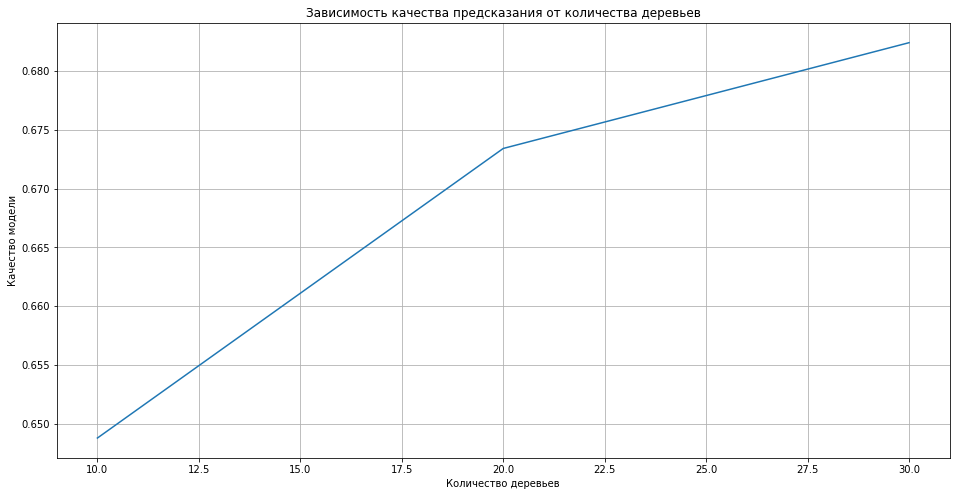

In [18]:
plt.subplots(figsize=(16, 8))
plt.plot(range(10, 40, 10), scores_gbm);
plt.title('Зависимость качества предсказания от количества деревьев')
plt.xlabel('Количество деревьев')
plt.ylabel('Качество модели')
plt.grid();

In [19]:
print(f'Качество градиентного бустинга при 30 деревьях: {max(scores_gbm):.2f}')

Качество градиентного бустинга при 30 деревьях: 0.68


Судя по графику при увеличении количества деревьев качество будет расти. Для ускорения обучения можно уменьшить количество признаков и более детально настроить гиперпараметры бустинга.

## Обучим логистическую регрессию на полном наборе данных

### Отмасштабируем признаки

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train)
X_test_scaled = scaler.transform(df_test)

In [21]:
def lr(data, c):
    lr_model = LogisticRegression(penalty='l2', C=c, random_state=42, solver='lbfgs')
    score = cross_val_score(lr_model, data, y, cv=kfold, scoring='roc_auc')
    return score.mean()

In [22]:
%%time
scores_lr_full = [lr(X_train_scaled, i) for i in [0.01, 0.001, 0.0001, 0.00001]]

CPU times: user 55.5 s, sys: 42.3 s, total: 1min 37s
Wall time: 9.48 s


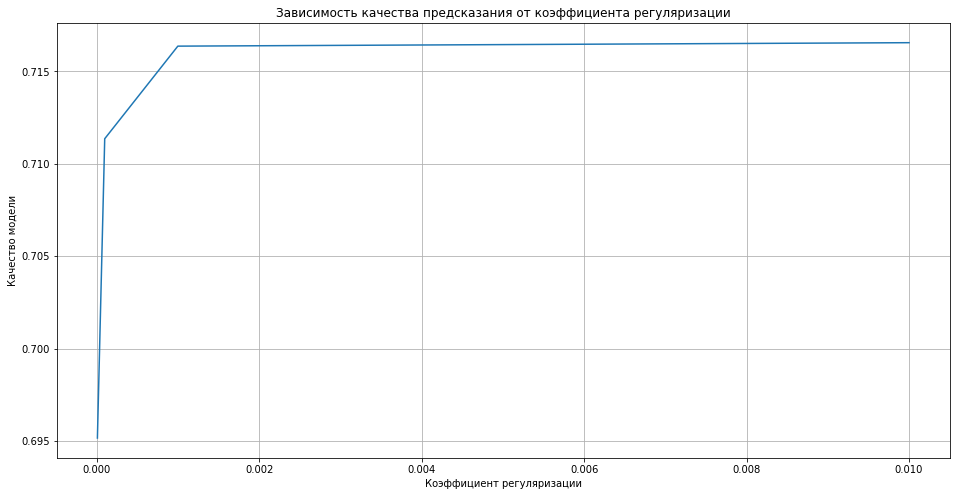

In [23]:
plt.subplots(figsize=(16, 8))
plt.plot([0.01, 0.001, 0.0001, 0.00001], scores_lr_full);
plt.title('Зависимость качества предсказания от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Качество модели')
plt.grid();

In [24]:
print(f'Качество логистической регресии с оптимальным параметром L2 регуляризации: {max(scores_lr_full):.2f}')

Качество логистической регресии с оптимальным параметром L2 регуляризации: 0.72


Логистическая регрессия обученная на всём датасете показала себя лучше чем градиентный бустинг, при том что обучалась она несопоставимо быстрее.

### Выделим категориальные признаки и удалим их из выборки

In [25]:
cat_var = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero',
           'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
X_train_cat = df_train.drop(cat_var, axis=1)
X_test_cat = df_test.drop(cat_var, axis=1)

In [26]:
X_train_cat.shape, X_test_cat.shape

((97230, 91), (17177, 91))

In [27]:
X_train_scaled_cat = scaler.fit_transform(X_train_cat)
X_test_scaled_cat = scaler.transform(X_test_cat)

In [28]:
%%time
scores_lr_cat = [lr(X_train_scaled_cat, i) for i in [0.01, 0.001, 0.0001, 0.00001]]

CPU times: user 49.6 s, sys: 41.7 s, total: 1min 31s
Wall time: 8.7 s


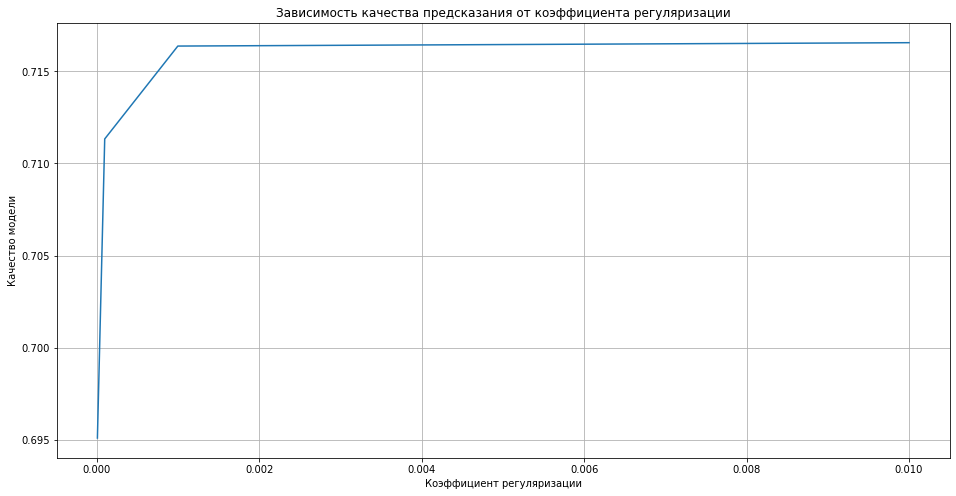

In [29]:
plt.subplots(figsize=(16, 8))
plt.plot([0.01, 0.001, 0.0001, 0.00001], scores_lr_cat);
plt.title('Зависимость качества предсказания от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Качество модели')
plt.grid();

In [30]:
print(f'Качество логистической регресии с оптимальным параметром L2 регуляризации: {max(scores_lr_cat):.2f}')

Качество логистической регресии с оптимальным параметром L2 регуляризации: 0.72


Логистическая регрессия обученная на датасете без категориальных признаков показала себя так же как и логистическая регресси обученная на полном датасете.

### Посчитаем количество уникальных героев

In [31]:
len_heros = df[[i for i in df.columns if 'hero' in i]].stack().max()
print(f'Количество уникальных героев {len_heros}')

Количество уникальных героев 112


## Воспользуемся подходом "мешок слов" для кодирования информации о героях

In [32]:
df_heroes = pd.read_csv('heroes.csv', index_col='id')
df_heroes.head()

,localized_name,name
id,,
1,Anti-Mage,antimage
2,Axe,axe
3,Bane,bane
4,Bloodseeker,bloodseeker
5,Crystal Maiden,crystal_maiden


In [33]:
df_heroes.shape

(112, 2)

In [34]:
X_pick = np.zeros((df.shape[0], df_heroes.shape[0]))
for i, match_id in enumerate(df.index):
    for p in range(5):
        X_pick[i, df.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, df.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
X_pick_df = pd.DataFrame(X_pick, index=df.index)

In [35]:
X_pick_df.head()

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_pick_df.shape

(97230, 112)

### Объединим выборку без категориальных признаков с выборкой по героям

In [37]:
df_concat = pd.concat([X_train_cat, X_pick_df], axis=1)
df_concat_scaled = scaler.fit_transform(df_concat)

In [38]:
%%time
scores_lr = [lr(df_concat_scaled, i) for i in [0.01, 0.001, 0.0001, 0.00001]]

CPU times: user 1min 31s, sys: 45.9 s, total: 2min 17s
Wall time: 12.4 s


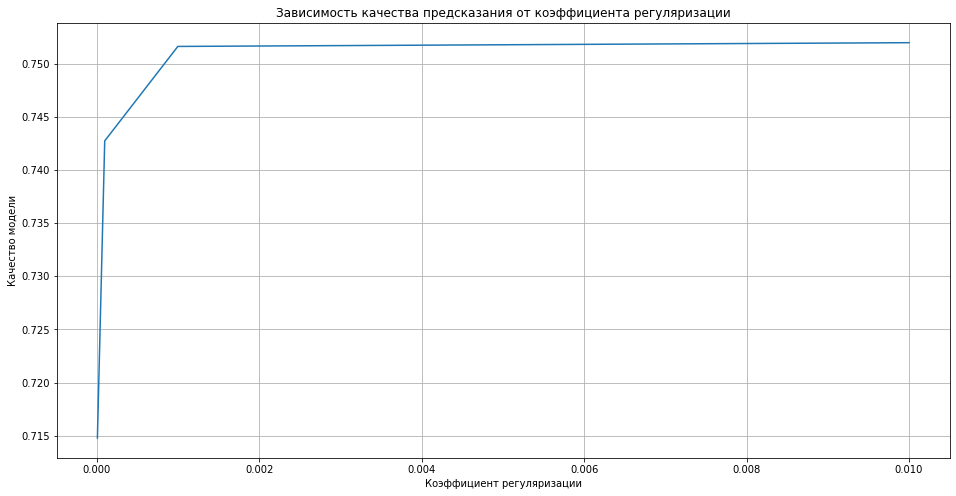

In [39]:
plt.subplots(figsize=(16, 8))
plt.plot([0.01, 0.001, 0.0001, 0.00001], scores_lr);
plt.title('Зависимость качества предсказания от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Качество модели')
plt.grid();

In [40]:
print(f'Качество логистической регресии с оптимальным параметром L2 регуляризации: {max(scores_lr):.2f}')

Качество логистической регресии с оптимальным параметром L2 регуляризации: 0.75


Качество модели выросло, так как были добавлены данные по героям.

## Сделаем предсказание победы на тестовой выборке с помощью лучшей модели

In [41]:
X_pick_test = np.zeros((df_test.shape[0], df_heroes.shape[0]))
for i, match_id in enumerate(df_test.index):
    for p in range(5):
        X_pick_test[i, df_test.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_test[i, df_test.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
X_pick_test_df = pd.DataFrame(X_pick_test, index=df_test.index)

In [42]:
X_test_concat = pd.concat([X_test_cat, X_pick_test_df], axis=1)
X_test_concat_scaled = scaler.transform(X_test_concat)

In [43]:
lr_model = LogisticRegression(penalty='l2', C=0.01, random_state=42, solver='lbfgs')

In [44]:
y_pred = lr_model.fit(df_concat_scaled, y).predict_proba(X_test_concat_scaled)

In [45]:
y_pred[:10]

array([[0.1772091 , 0.8227909 ],
       [0.24783317, 0.75216683],
       [0.81093299, 0.18906701],
       [0.14236099, 0.85763901],
       [0.75603649, 0.24396351],
       [0.62590402, 0.37409598],
       [0.4740248 , 0.5259752 ],
       [0.4364639 , 0.5635361 ],
       [0.782875  , 0.217125  ],
       [0.32713483, 0.67286517]])

In [46]:
round(y_pred[:, 1].min(), 2), round(y_pred[:, 1].max(), 2)

(0.01, 1.0)

### Получившаяся модель предсказывает вероятности того, что какая-то из команд победила достаточно уверенно, не является константной так как все значения находятся в диапазоне от 0 да 1